# Sentiment Analysis

In [ ]:
!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy -O "data/IMDB-Dataset.csv"

In [ ]:
!pip install -r requirements.txt

In [ ]:
import re
import string
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Load Dataset

In [40]:
df = pd.read_csv("data/IMDB-Dataset.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Preprocessing

### Drop duplicate rows

In [42]:
df.duplicated().sum()

418

In [43]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Removing HTML, Expanding Contractions, and Lemmatization

In [ ]:
stop = set(stopwords.words("english"))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)


# Clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    
    # remove html tags
    soup = BeautifulSoup(text, "html.parser")
    
    # Expanding chatwords and contracts clearing contractions
    text = soup.get_text()
    text = expand_contractions(text)
    
    emoji_clean = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # enclosed characters
        "]+", flags=re.UNICODE
    )
    
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # Add space after full stop
    text = re.sub(r'http\S+', '', text) # Remove urls
    text = "".join([
        char.lower() for char in text if char not in string.punctuation # Remove punctuation and make text lowercase
    ])
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha() # Lemmatize
    ])
    return text


df["review"] = df["review"].apply(preprocess_text)

### Calculating Sentiment Frequencies for Positive and Negative Reviews

In [46]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df["sentiment"] == "positive"])
freq_neg = len(df[df["sentiment"] == "negative"])

data = [freq_pos, freq_neg]
data

[24884, 24698]

### Creating a Pie Chart for Sentiment Distribution

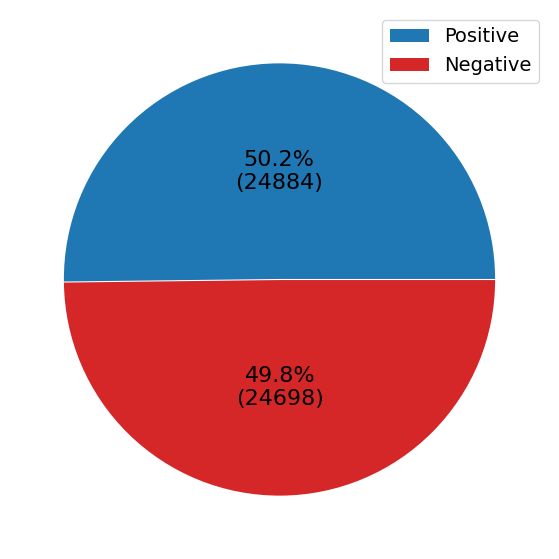

In [47]:
labels = ["positive", "negative"]

# create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(
    x=data, 
    autopct=lambda pct: func(pct, data), 
    explode=[0.0025]*2,
    pctdistance=0.5,
    colors=[sns.color_palette()[0], "tab:red"],
    textprops={"fontsize": 16}
)

labels = [r"Positive", r"Negative"]
plt.legend(labels, loc="best", prop={"size": 14})
pie.savefig("PieChart.png")
plt.show()

### Word Length Distribution in Positive and Negative Reviews

In [48]:
words_len = df["review"].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp["words length"] = words_len
df_temp.head(5)

,review,sentiment,words length
0,one reviewer mentioned watching oz episode hoo...,positive,162
1,wonderful little production filming technique ...,positive,84
2,thought wonderful way spend time hot summer we...,positive,84
3,basically family little boy jake think zombie ...,negative,64
4,petter matteis love time money visually stunni...,positive,125


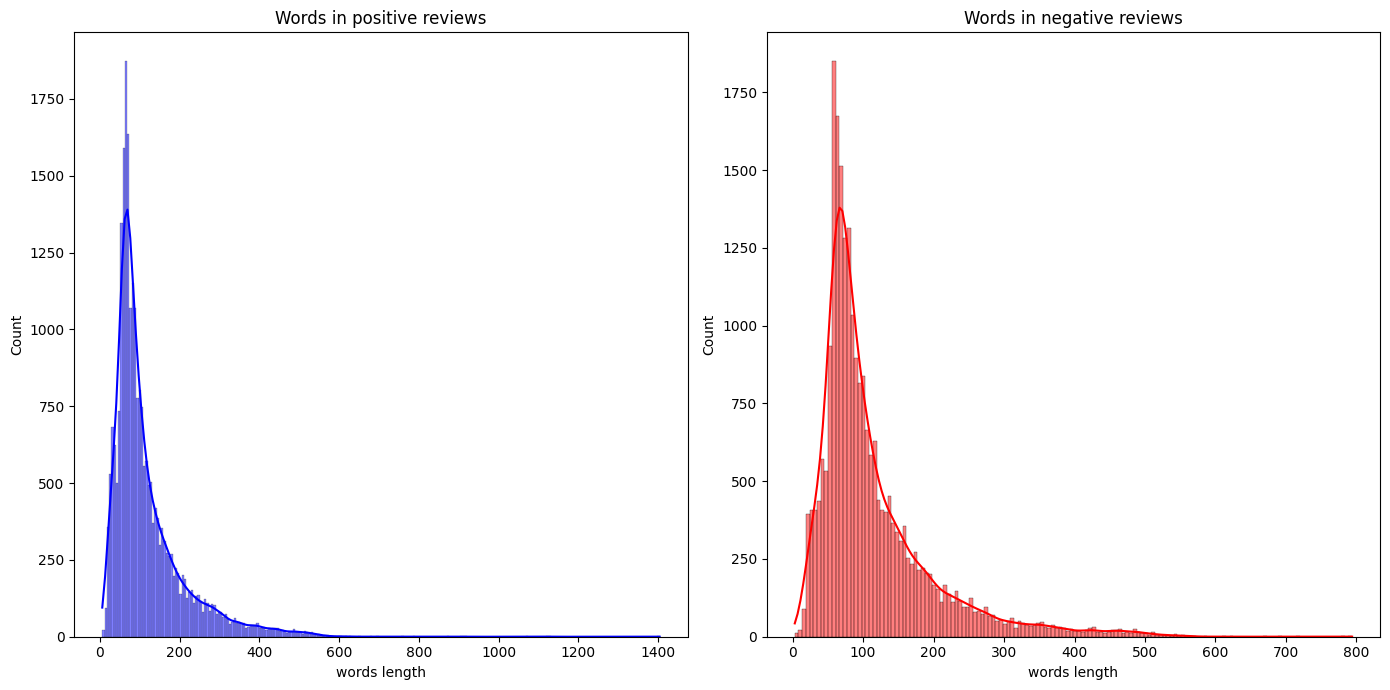

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

hist_positive = sns.histplot(
    data=df_temp[df_temp["sentiment"] == "positive"],
    x="words length",
    kde=True,
    ax=ax1,
    color="blue"
).set(title="Words in positive reviews")

hist_negative = sns.histplot(
    data=df_temp[df_temp["sentiment"] == "negative"],
    x="words length",
    kde=True,
    ax=ax2,
    color="red"
).set(title="Words in negative reviews")

plt.tight_layout()
plt.show()

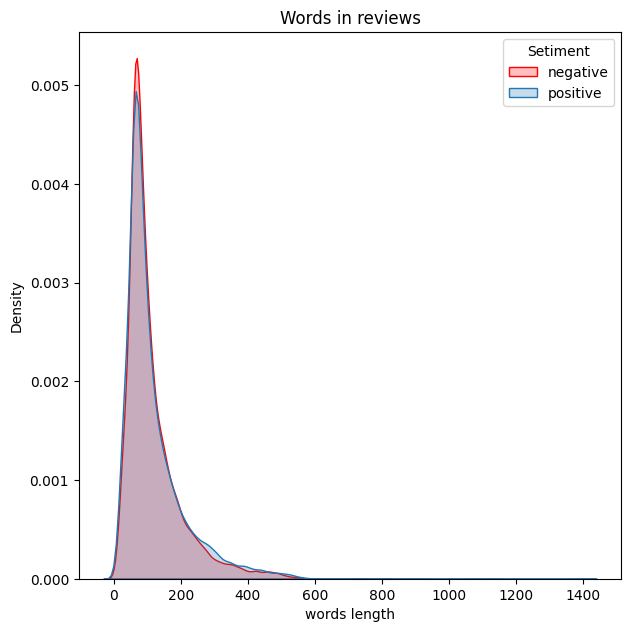

In [59]:
plt.figure(figsize=(7, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp,
    x="words length",
    hue="sentiment",
    fill=True,
    palette=[sns.color_palette()[0], "red"]
).set(title="Words in reviews")

plt.legend(title="Setiment", labels=["negative", "positive"])
plt.show(kernel_distibution_number_words_plot)

### Label Encoding and Train-Test Split

In [67]:
label_encode = LabelEncoder()

X_data = df["review"]
y_data = label_encode.fit_transform(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

X_train.shape, X_text.shape

((39665,), (9917,))

### TF-IDF Vectorization of Reviews

In [68]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train, y_train)

X_train_encoded = tfidf_vectorizer.transform(X_train)
X_test_encoded = tfidf_vectorizer.transform(X_test)

In [83]:
vocab = tfidf_vectorizer.vocabulary_
len(vocab)

10000

## Training and Evaluating Accuracy

### Decision Tree Classifier

In [70]:
dt_classifier = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_classifier.fit(X_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [72]:
y_pred = dt_classifier.predict(X_test_encoded)
accuracy_score(y_pred, y_test)

0.7139255823333669

### Random Forest Classifier

In [73]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

In [74]:
y_pred = rf_classifier.predict(X_test_encoded)
accuracy_score(y_pred, y_test)

0.8416859937481093